# SELF-SUPERVISED DENOISING: PART ONE
### Authors: Claire Birnie and Sixiu Liu, KAUST

Author websites: 
- https://cebirnie92.github.io/ 
- https://swagroup.kaust.edu.sa/people/detail/sixiu-liu-(%E5%88%98%E6%80%9D%E7%A7%80))

## Tutorial Overview

On completion of this tutorial you will have learnt how to write your own blind-spot denoising procedure that is trained in a self-supervised manner, i.e., the training data is the same as the inference data with no labels required!

### Methodology Recap
We will implement the Noise2Void 

***

In [1]:
# Import necessary packages
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader 

# Our unet functions just to speed things up
from unet import UNet
from tutorial_utils import regular_patching_2D, add_whitegaussian_noise

In [2]:
cmap='RdBu'
vmin = -0.5
vmax = 0.5

***

# Step One - Data loading

In this example we are going to use a post-stack seismic section generated from the Hess VTI model. The post-stack section is available in the data folder of the repository: https://github.com/swag-kaust/Transform2022_SelfSupervisedDenoising

In [3]:
d = np.load("/ibex/scratch/birniece/Transform2022_SelfSupervisedDenoising/data/Hess_poststack.npy")
d /= np.max(abs(d))
print(d.shape)

(198, 453)


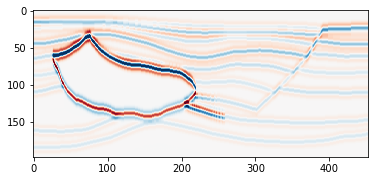

In [4]:
# Plot to see the noise free data
plt.imshow(d, cmap=cmap, vmin=vmin, vmax=vmax)

### Add noise

In [5]:
noisydata, _ = add_whitegaussian_noise(d, sc=0.1)

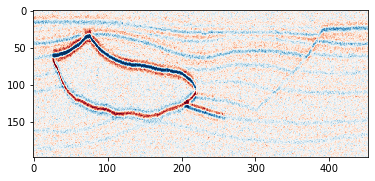

In [6]:
# plot to see the noisy data
plt.imshow(noisydata, cmap=cmap, vmin=vmin, vmax=vmax)

### Patch data

In [7]:
noisy_patches = regular_patching_2D(noisydata, 
                                    patchsize=[64, 64], 
                                    step=[8,8])

Extracting 833 patches


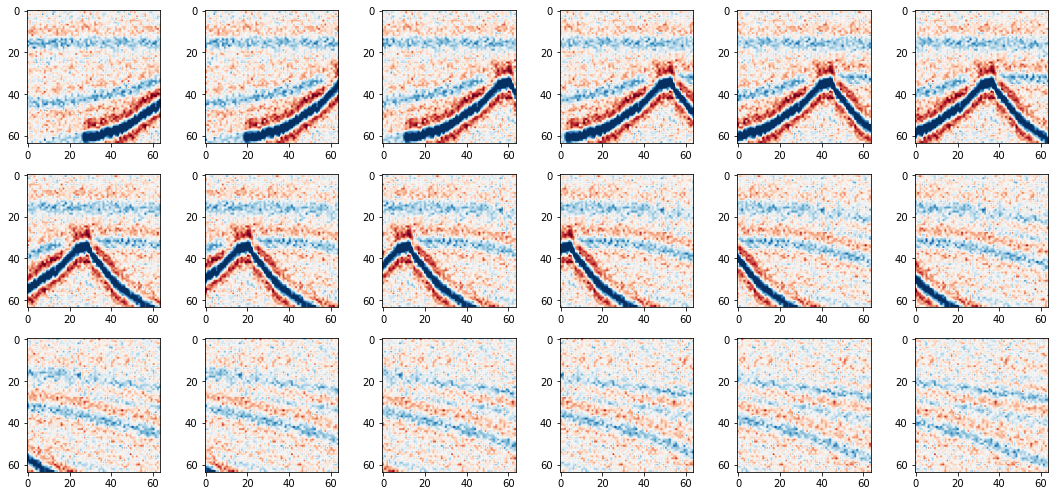

In [8]:
fig, axs = plt.subplots(3,6,figsize=[15,7])
for i in range(6*3):
    axs.ravel()[i].imshow(noisy_patches[i], cmap=cmap, vmin=vmin, vmax=vmax)
fig.tight_layout()

### Augment patches: multiply by -1 and mirror on Z-axis

In [9]:
polrev_patches = noisy_patches * -1
or_patches = np.vstack([noisy_patches,polrev_patches])
mir_patches = np.array([np.fliplr(patch) for patch in or_patches])
aug_patches = np.vstack([or_patches,mir_patches])
print('Number of patches after augmentation: ', aug_patches.shape)

Number of patches after augmentation:  (3332, 64, 64)


***

# Step Two - Blindspot corruption of training data

In [10]:
# Create a function that randomly selects and corrupts pixels following N2V methodology
def multi_active_pixels(patch, 
                        num_activepixels, 
                        neighbourhood_radius=5, 
                        swap=True):

    n_rad = neighbourhood_radius  # descriptive variable name too long

    # Select multiple locations for active pixels
    idx_aps = np.random.randint(0, patch.shape[0], num_activepixels)
    idy_aps = np.random.randint(0, patch.shape[1], num_activepixels)

    # For each active pixel compute shift for finding neighbouring pixel and find pixel
    x_neigh_shft = np.random.randint(-n_rad // 2 + n_rad % 2, n_rad // 2 + n_rad % 2, num_activepixels)
    y_neigh_shft = np.random.randint(-n_rad // 2 + n_rad % 2, n_rad // 2 + n_rad % 2, num_activepixels)
    
    # OPTIONAL: don't allow replacement with itself
    for i in range(len(x_neigh_shft)):
        if x_neigh_shft[i] == 0 and y_neigh_shft[i] == 0:
            # This means its replacing itself with itself...not good!
            shft_options = np.trim_zeros(np.arange(-n_rad // 2 + 1, n_rad // 2 + 1))
            x_neigh_shft[i] = np.random.choice(shft_options[shft_options != 0], 1)

    # Find x and y locations of neighbours for the replacement
    idx_neigh = idx_aps + x_neigh_shft
    idy_neigh = idy_aps + y_neigh_shft

    # Make sure neighbouring pixels within window
    idx_neigh = idx_neigh + (idx_neigh < 0) * patch.shape[0] - (idx_neigh >= patch.shape[0]) * patch.shape[0]
    idy_neigh = idy_neigh + (idy_neigh < 0) * patch.shape[1] - (idy_neigh >= patch.shape[1]) * patch.shape[1]
    
    # combine x and y coordinates for active pixels and neighbouring pixels
    id_aps = (idx_aps, idy_aps)
    id_neigh = (idx_neigh, idy_neigh)
    
    # Make mask and corrupted patch
    mask = np.ones_like(patch)
    cp_ptch = patch.copy()
    mask[id_aps] = 0.
    if swap:
        cp_ptch[id_aps] = patch[id_neigh]
    else:
        cp_ptch[id_aps] = 0

    return cp_ptch, mask


In [11]:
# Check the corruption function works
crpt_patch, mask = multi_active_pixels(noisy_patches[0], 
                                  num_activepixels=50, 
                                  neighbourhood_radius=5, 
                                  swap=True)

Text(0.5, 1.0, 'Corruption Mask')

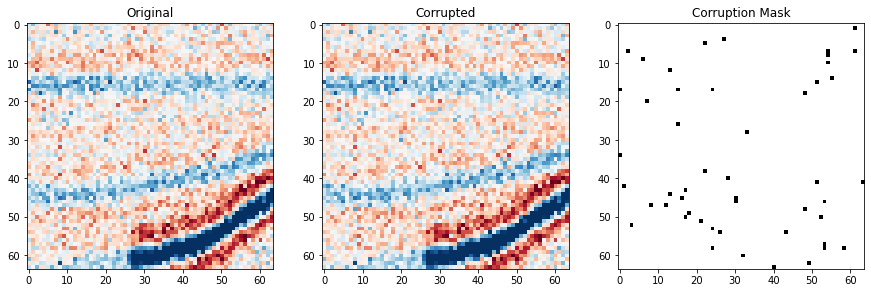

In [12]:
fig,axs = plt.subplots(1,3,figsize=[15,5])
axs[0].imshow(noisy_patches[0], cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].imshow(crpt_patch, cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].imshow(mask, cmap='binary_r')

axs[0].set_title('Original')
axs[1].set_title('Corrupted')
axs[2].set_title('Corruption Mask')

***

# Step three - Set up network

In [13]:
# Select device for training
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = torch.device(torch.cuda.current_device())
    print(f'Device: {device} {torch.cuda.get_device_name(device)}')
else:
    print("No GPU available!")

Cuda installed! Running on GPU!
Device: cuda:0 NVIDIA Tesla V100-SXM2-32GB


In [14]:
# Build UNet
network = UNet(input_channels=1, 
               output_channels=1, 
               hidden_channels=32,
               levels=2).to(device)


In [15]:
# Network initialisation steps
n_epochs = 100
lr = 0.0001
criterion = nn.MSELoss()
optim = torch.optim.Adam(network.parameters(), lr=lr)

In [16]:
# Data training parameters
n_training = 3000

perc_active = 5
total_num_pixels = noisy_patches[0].shape[0]*noisy_patches[0].shape[1]
num_activepixels = np.floor((total_num_pixels/100) * perc_active)
print(num_activepixels)

204.0


***

# Step four - training

In [17]:
# Initial train and val 
train_loss_history = np.zeros(n_epochs)
train_accuracy_history = np.zeros(n_epochs)
val_loss_history = np.zeros(n_epochs)
val_accuracy_history = np.zeros(n_epochs)

# Create DataLoaders fixing the generator for reproducibily
g = torch.Generator()
g.manual_seed(0)

In [18]:
def n2v_train(model, 
              criterion, 
              optimizer, 
              data_loader, 
              device):
    
    model.train()
    accuracy = 0
    loss = 0

    for dl in tqdm(data_loader):
        X, y, mask = dl[0], dl[1], dl[2]
        X, y, mask = X.to(device), y.to(device), mask.to(device)
        optimizer.zero_grad()
        yprob = model(X)

        # TO DO: Compute loss function only at masked locations
        # (Hint: only one line required)
        ls = criterion(yprob * (1 - mask), y * (1 - mask))
        
        ls.backward()
        optimizer.step()
        with torch.no_grad():
            yprob = yprob
            ypred = (yprob.detach().cpu().numpy()).astype(float)
        loss += ls.item()
        accuracy += np.sqrt(np.mean((y.cpu().numpy().ravel( ) - ypred.ravel() )**2))
        
    loss /= len(data_loader)
    accuracy /= len(data_loader)   

    return loss, accuracy

In [19]:
# TRAINING
for ep in range(n_epochs):  
    
    # RANDOMLY CORRUPT THE NOISY PATCHES
    corrupted_patches = np.zeros_like(noisy_patches)
    masks = np.zeros_like(corrupted_patches)
    for pi in range(len(noisy_patches)):
        corrupted_patches[pi], masks[pi] = multi_active_pixels(noisy_patches[pi], 
                                                               num_activepixels=int(num_activepixels), 
                                                               neighbourhood_radius=5, 
                                                               swap=True
                                                              )

    # MAKE DATA LOADERS
    # Remember to add 1 to 2nd dim - Pytorch is [#data, #channels, height, width]
    # Define Train Set
    train_X = np.expand_dims(corrupted_patches[:n_training],axis=1)
    train_y = np.expand_dims(noisy_patches[:n_training],axis=1)    
    msk = np.expand_dims(masks[:n_training],axis=1)    
    
    X_train = torch.from_numpy(train_X).float()
    y_train = torch.from_numpy(train_y).float()
    train_dataset = TensorDataset(X_train, 
                                  y_train, 
                                  torch.from_numpy(msk).float(),)

    # Define Test Set
    test_X = np.expand_dims(corrupted_patches[n_training:],axis=1)
    test_y = np.expand_dims(noisy_patches[n_training:],axis=1)
    msk = np.expand_dims(masks[n_training:],axis=1) 
    X_test = torch.from_numpy(test_X).float()
    y_test = torch.from_numpy(test_y).float()
    test_dataset = TensorDataset(X_test, 
                                 y_test, 
                                 torch.from_numpy(msk).float(),)

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, generator=g)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    # TRAIN
    train_loss, train_accuracy = n2v_train(network, 
                                           criterion, 
                                           optim, 
                                           train_loader, 
                                           device,)

#     test_loss, test_accuracy, test_metrics = n2v_evaluate(network, 
#                                                            criterion,
#                                                            test_loader, 
#                                                            device,
#                                                             synth=False,
#                                                             plotflag=True if ep%5==0 else False)

    train_loss_history[ep], train_accuracy_history[ep] = train_loss, train_accuracy
#     test_loss_history[ep], test_accuracy_history[ep] = test_loss, test_accuracy

    print(f'''Epoch {ep}, 
    Training Loss {train_loss:.4f},     Training Accuracy {train_accuracy:.4f}, ''')
#     Test Loss {test_loss:.4f},     Test Accuracy {test_accuracy:.4f} ''')



100%|██████████| 7/7 [00:01<00:00,  4.50it/s]


Epoch 0, 
    Training Loss 0.0011,     Training Accuracy 0.1509, 


100%|██████████| 7/7 [00:01<00:00,  5.32it/s]


Epoch 1, 
    Training Loss 0.0009,     Training Accuracy 0.1342, 


100%|██████████| 7/7 [00:01<00:00,  5.29it/s]


Epoch 2, 
    Training Loss 0.0007,     Training Accuracy 0.1181, 


100%|██████████| 7/7 [00:01<00:00,  5.31it/s]


Epoch 3, 
    Training Loss 0.0007,     Training Accuracy 0.1133, 


100%|██████████| 7/7 [00:01<00:00,  5.30it/s]


Epoch 4, 
    Training Loss 0.0006,     Training Accuracy 0.1118, 


100%|██████████| 7/7 [00:01<00:00,  5.30it/s]


Epoch 5, 
    Training Loss 0.0006,     Training Accuracy 0.1095, 


100%|██████████| 7/7 [00:01<00:00,  5.31it/s]


Epoch 6, 
    Training Loss 0.0006,     Training Accuracy 0.1081, 


100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 7, 
    Training Loss 0.0006,     Training Accuracy 0.1065, 


100%|██████████| 7/7 [00:01<00:00,  5.31it/s]


Epoch 8, 
    Training Loss 0.0006,     Training Accuracy 0.1055, 


100%|██████████| 7/7 [00:01<00:00,  5.29it/s]


Epoch 9, 
    Training Loss 0.0006,     Training Accuracy 0.1047, 


100%|██████████| 7/7 [00:01<00:00,  5.29it/s]


Epoch 10, 
    Training Loss 0.0006,     Training Accuracy 0.1040, 


100%|██████████| 7/7 [00:01<00:00,  5.27it/s]


Epoch 11, 
    Training Loss 0.0006,     Training Accuracy 0.1039, 


100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 12, 
    Training Loss 0.0006,     Training Accuracy 0.1035, 


100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 13, 
    Training Loss 0.0006,     Training Accuracy 0.1034, 


100%|██████████| 7/7 [00:01<00:00,  5.30it/s]


Epoch 14, 
    Training Loss 0.0006,     Training Accuracy 0.1030, 


100%|██████████| 7/7 [00:01<00:00,  5.30it/s]


Epoch 15, 
    Training Loss 0.0006,     Training Accuracy 0.1029, 


100%|██████████| 7/7 [00:01<00:00,  5.29it/s]


Epoch 16, 
    Training Loss 0.0006,     Training Accuracy 0.1030, 


100%|██████████| 7/7 [00:01<00:00,  5.31it/s]


Epoch 17, 
    Training Loss 0.0006,     Training Accuracy 0.1032, 


100%|██████████| 7/7 [00:01<00:00,  5.27it/s]


Epoch 18, 
    Training Loss 0.0005,     Training Accuracy 0.1028, 


100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 19, 
    Training Loss 0.0005,     Training Accuracy 0.1028, 


100%|██████████| 7/7 [00:01<00:00,  5.32it/s]


Epoch 20, 
    Training Loss 0.0005,     Training Accuracy 0.1027, 


100%|██████████| 7/7 [00:01<00:00,  5.29it/s]


Epoch 21, 
    Training Loss 0.0005,     Training Accuracy 0.1029, 


100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 22, 
    Training Loss 0.0005,     Training Accuracy 0.1029, 


100%|██████████| 7/7 [00:01<00:00,  5.31it/s]


Epoch 23, 
    Training Loss 0.0006,     Training Accuracy 0.1035, 


100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 24, 
    Training Loss 0.0005,     Training Accuracy 0.1029, 


100%|██████████| 7/7 [00:01<00:00,  5.31it/s]


Epoch 25, 
    Training Loss 0.0005,     Training Accuracy 0.1028, 


100%|██████████| 7/7 [00:01<00:00,  5.30it/s]


Epoch 26, 
    Training Loss 0.0005,     Training Accuracy 0.1031, 


100%|██████████| 7/7 [00:01<00:00,  5.29it/s]


Epoch 27, 
    Training Loss 0.0005,     Training Accuracy 0.1032, 


100%|██████████| 7/7 [00:01<00:00,  5.29it/s]


Epoch 28, 
    Training Loss 0.0005,     Training Accuracy 0.1031, 


100%|██████████| 7/7 [00:01<00:00,  5.31it/s]


Epoch 29, 
    Training Loss 0.0005,     Training Accuracy 0.1030, 


100%|██████████| 7/7 [00:01<00:00,  5.24it/s]


Epoch 30, 
    Training Loss 0.0005,     Training Accuracy 0.1033, 


100%|██████████| 7/7 [00:01<00:00,  5.29it/s]


Epoch 31, 
    Training Loss 0.0005,     Training Accuracy 0.1031, 


100%|██████████| 7/7 [00:01<00:00,  5.29it/s]


Epoch 32, 
    Training Loss 0.0005,     Training Accuracy 0.1033, 


100%|██████████| 7/7 [00:01<00:00,  5.30it/s]


Epoch 33, 
    Training Loss 0.0005,     Training Accuracy 0.1035, 


100%|██████████| 7/7 [00:01<00:00,  5.31it/s]


Epoch 34, 
    Training Loss 0.0005,     Training Accuracy 0.1033, 


100%|██████████| 7/7 [00:01<00:00,  5.29it/s]


Epoch 35, 
    Training Loss 0.0005,     Training Accuracy 0.1034, 


100%|██████████| 7/7 [00:01<00:00,  5.30it/s]


Epoch 36, 
    Training Loss 0.0005,     Training Accuracy 0.1035, 


100%|██████████| 7/7 [00:01<00:00,  5.27it/s]


Epoch 37, 
    Training Loss 0.0005,     Training Accuracy 0.1036, 


100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 38, 
    Training Loss 0.0005,     Training Accuracy 0.1035, 


100%|██████████| 7/7 [00:01<00:00,  5.27it/s]


Epoch 39, 
    Training Loss 0.0005,     Training Accuracy 0.1035, 


100%|██████████| 7/7 [00:01<00:00,  5.30it/s]


Epoch 40, 
    Training Loss 0.0005,     Training Accuracy 0.1037, 


100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 41, 
    Training Loss 0.0005,     Training Accuracy 0.1037, 


100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 42, 
    Training Loss 0.0005,     Training Accuracy 0.1035, 


100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 43, 
    Training Loss 0.0005,     Training Accuracy 0.1036, 


100%|██████████| 7/7 [00:01<00:00,  5.29it/s]


Epoch 44, 
    Training Loss 0.0005,     Training Accuracy 0.1036, 


100%|██████████| 7/7 [00:01<00:00,  5.29it/s]


Epoch 45, 
    Training Loss 0.0005,     Training Accuracy 0.1039, 


100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 46, 
    Training Loss 0.0005,     Training Accuracy 0.1038, 


100%|██████████| 7/7 [00:01<00:00,  5.30it/s]


Epoch 47, 
    Training Loss 0.0005,     Training Accuracy 0.1037, 


100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 48, 
    Training Loss 0.0005,     Training Accuracy 0.1037, 


100%|██████████| 7/7 [00:01<00:00,  5.30it/s]


Epoch 49, 
    Training Loss 0.0005,     Training Accuracy 0.1038, 


100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 50, 
    Training Loss 0.0005,     Training Accuracy 0.1037, 


100%|██████████| 7/7 [00:01<00:00,  5.30it/s]


Epoch 51, 
    Training Loss 0.0005,     Training Accuracy 0.1039, 


100%|██████████| 7/7 [00:01<00:00,  5.30it/s]


Epoch 52, 
    Training Loss 0.0005,     Training Accuracy 0.1038, 


100%|██████████| 7/7 [00:01<00:00,  5.26it/s]


Epoch 53, 
    Training Loss 0.0005,     Training Accuracy 0.1038, 


100%|██████████| 7/7 [00:01<00:00,  5.26it/s]


Epoch 54, 
    Training Loss 0.0005,     Training Accuracy 0.1038, 


100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 55, 
    Training Loss 0.0005,     Training Accuracy 0.1038, 


100%|██████████| 7/7 [00:01<00:00,  5.29it/s]


Epoch 56, 
    Training Loss 0.0005,     Training Accuracy 0.1038, 


100%|██████████| 7/7 [00:01<00:00,  5.25it/s]


Epoch 57, 
    Training Loss 0.0005,     Training Accuracy 0.1038, 


100%|██████████| 7/7 [00:01<00:00,  5.30it/s]


Epoch 58, 
    Training Loss 0.0005,     Training Accuracy 0.1039, 


100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 59, 
    Training Loss 0.0005,     Training Accuracy 0.1038, 


100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 60, 
    Training Loss 0.0005,     Training Accuracy 0.1039, 


100%|██████████| 7/7 [00:01<00:00,  5.29it/s]


Epoch 61, 
    Training Loss 0.0005,     Training Accuracy 0.1038, 


100%|██████████| 7/7 [00:01<00:00,  5.27it/s]


Epoch 62, 
    Training Loss 0.0005,     Training Accuracy 0.1038, 


100%|██████████| 7/7 [00:01<00:00,  5.29it/s]


Epoch 63, 
    Training Loss 0.0005,     Training Accuracy 0.1039, 


100%|██████████| 7/7 [00:01<00:00,  5.30it/s]


Epoch 64, 
    Training Loss 0.0005,     Training Accuracy 0.1039, 


100%|██████████| 7/7 [00:01<00:00,  5.29it/s]


Epoch 65, 
    Training Loss 0.0005,     Training Accuracy 0.1038, 


100%|██████████| 7/7 [00:01<00:00,  5.26it/s]


Epoch 66, 
    Training Loss 0.0005,     Training Accuracy 0.1037, 


100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 67, 
    Training Loss 0.0005,     Training Accuracy 0.1040, 


100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 68, 
    Training Loss 0.0005,     Training Accuracy 0.1038, 


100%|██████████| 7/7 [00:01<00:00,  5.27it/s]


Epoch 69, 
    Training Loss 0.0005,     Training Accuracy 0.1038, 


100%|██████████| 7/7 [00:01<00:00,  5.29it/s]


Epoch 70, 
    Training Loss 0.0005,     Training Accuracy 0.1037, 


100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 71, 
    Training Loss 0.0005,     Training Accuracy 0.1038, 


100%|██████████| 7/7 [00:01<00:00,  5.26it/s]


Epoch 72, 
    Training Loss 0.0005,     Training Accuracy 0.1038, 


100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 73, 
    Training Loss 0.0005,     Training Accuracy 0.1039, 


100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 74, 
    Training Loss 0.0005,     Training Accuracy 0.1039, 


100%|██████████| 7/7 [00:01<00:00,  5.30it/s]


Epoch 75, 
    Training Loss 0.0005,     Training Accuracy 0.1039, 


100%|██████████| 7/7 [00:01<00:00,  5.29it/s]


Epoch 76, 
    Training Loss 0.0005,     Training Accuracy 0.1041, 


100%|██████████| 7/7 [00:01<00:00,  5.30it/s]


Epoch 77, 
    Training Loss 0.0005,     Training Accuracy 0.1041, 


100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 78, 
    Training Loss 0.0005,     Training Accuracy 0.1039, 


100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 79, 
    Training Loss 0.0005,     Training Accuracy 0.1038, 


100%|██████████| 7/7 [00:01<00:00,  5.27it/s]


Epoch 80, 
    Training Loss 0.0005,     Training Accuracy 0.1039, 


100%|██████████| 7/7 [00:01<00:00,  5.27it/s]


Epoch 81, 
    Training Loss 0.0005,     Training Accuracy 0.1038, 


100%|██████████| 7/7 [00:01<00:00,  5.30it/s]


Epoch 82, 
    Training Loss 0.0005,     Training Accuracy 0.1039, 


100%|██████████| 7/7 [00:01<00:00,  5.27it/s]


Epoch 83, 
    Training Loss 0.0005,     Training Accuracy 0.1040, 


100%|██████████| 7/7 [00:01<00:00,  5.27it/s]


Epoch 84, 
    Training Loss 0.0005,     Training Accuracy 0.1039, 


100%|██████████| 7/7 [00:01<00:00,  5.27it/s]


Epoch 85, 
    Training Loss 0.0005,     Training Accuracy 0.1038, 


100%|██████████| 7/7 [00:01<00:00,  5.30it/s]


Epoch 86, 
    Training Loss 0.0005,     Training Accuracy 0.1037, 


100%|██████████| 7/7 [00:01<00:00,  5.27it/s]


Epoch 87, 
    Training Loss 0.0005,     Training Accuracy 0.1037, 


100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 88, 
    Training Loss 0.0005,     Training Accuracy 0.1037, 


100%|██████████| 7/7 [00:01<00:00,  5.27it/s]


Epoch 89, 
    Training Loss 0.0005,     Training Accuracy 0.1038, 


100%|██████████| 7/7 [00:01<00:00,  5.27it/s]


Epoch 90, 
    Training Loss 0.0005,     Training Accuracy 0.1037, 


100%|██████████| 7/7 [00:01<00:00,  5.27it/s]


Epoch 91, 
    Training Loss 0.0005,     Training Accuracy 0.1036, 


100%|██████████| 7/7 [00:01<00:00,  5.29it/s]


Epoch 92, 
    Training Loss 0.0005,     Training Accuracy 0.1036, 


100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 93, 
    Training Loss 0.0005,     Training Accuracy 0.1036, 


100%|██████████| 7/7 [00:01<00:00,  5.28it/s]


Epoch 94, 
    Training Loss 0.0005,     Training Accuracy 0.1036, 


100%|██████████| 7/7 [00:01<00:00,  5.29it/s]


Epoch 95, 
    Training Loss 0.0005,     Training Accuracy 0.1036, 


100%|██████████| 7/7 [00:01<00:00,  5.26it/s]


Epoch 96, 
    Training Loss 0.0005,     Training Accuracy 0.1037, 


100%|██████████| 7/7 [00:01<00:00,  5.25it/s]


Epoch 97, 
    Training Loss 0.0005,     Training Accuracy 0.1038, 


100%|██████████| 7/7 [00:01<00:00,  5.27it/s]


Epoch 98, 
    Training Loss 0.0005,     Training Accuracy 0.1037, 


100%|██████████| 7/7 [00:01<00:00,  5.28it/s]

Epoch 99, 
    Training Loss 0.0005,     Training Accuracy 0.1038, 


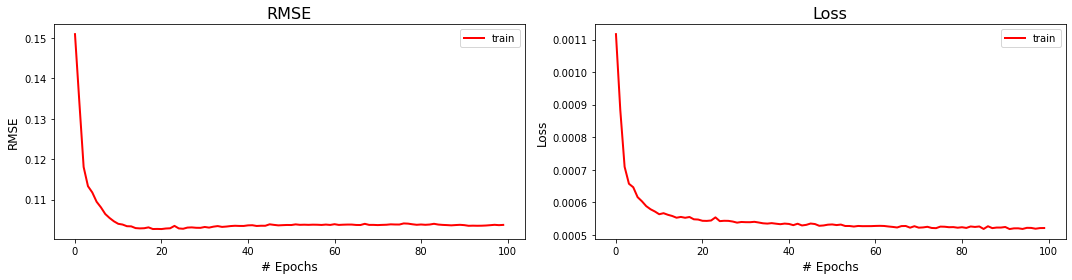

In [20]:
fig,axs = plt.subplots(1,2,figsize=(15,4))

axs[0].plot(train_accuracy_history, 'r', lw=2, label='train')
# axs[0].plot(test_accuracy_history, 'k', lw=2, label='validation')
axs[0].set_title('RMSE', size=16)
axs[0].set_ylabel('RMSE', size=12)

axs[1].plot(train_loss_history, 'r', lw=2, label='train')
# axs[1].plot(test_loss_history, 'k', lw=2, label='validation')
axs[1].set_title('Loss', size=16)
axs[1].set_ylabel('Loss', size=12)


for ax in axs:
    ax.legend()
    ax.set_xlabel('# Epochs', size=12)
fig.tight_layout()

***

## Step five - apply trained model

In [21]:
d.shape

(198, 453)

In [22]:
# Make a new noisy realisation so it's different from the training set
testdata, _ = add_whitegaussian_noise(d[:196,:452], sc=0.1)

In [23]:
torch_testdata = torch.from_numpy(np.expand_dims(np.expand_dims(testdata,axis=0),axis=0)).float()
test_prediction = network(torch_testdata.to(device))
test_pred = test_prediction.detach().cpu().numpy().squeeze()

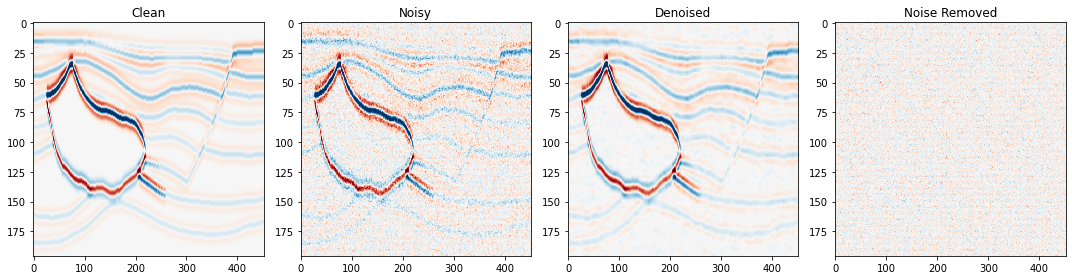

In [24]:
fig,axs = plt.subplots(1,4,figsize=[15,4])
axs[0].imshow(d[:196,:452], aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].imshow(testdata, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
axs[2].imshow(test_pred, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
axs[3].imshow(testdata-test_pred, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)

axs[0].set_title('Clean')
axs[1].set_title('Noisy')
axs[2].set_title('Denoised')
axs[3].set_title('Noise Removed')

fig.tight_layout()